# C2 Galaxy Cluster Injection


In this notebook we process the rendered galaxy catalogs using the sextractor software, and transport them into a multi-epoch data system, which will later be used to interface with metacalibration


## Objectives

    1 Learn to create MEDS files 
    
    2 Prepare for running metacalibration
 

**TODO** Check the weight map, with someone expert


## Setup

This notebook relies on the:

    * synthetic package & dependencies
    
    * prepared & curated DC2 cutout data file


## Output

    * MEDS data file
    
The output files are placed in the `./data/` folder


## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [47]:
import fitsio as fio
import numpy as np
import pandas as pd
import pickle as pickle
import copy
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import galsim
import astropy.cosmology as cosmology

import images # package from erin sheldon

import synthetic.tools as tools
import synthetic.render.frame as frame
import synthetic.render.render as render

import meds
import psfex # The python wrapper

pixel_scale = 0.2

# Create a rendered image we are going to work on

and run source extractor

This part reproduces where largely identical to the B2 left off

In [22]:
# File path for input DC2 files
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/" 
# output path for mock image, be sure to place it into 
out_path = "data/"

Now we load an arbitrary chunk of DC2, in this case orderedd by a list of healpix pixel cutotuts.

In [23]:
table_path = '/e/ocean1/users/vargatn/LSST/SYNTHETIC/curated_table.h5'
table = pd.read_hdf(table_path, key="data")

ra_cen = 50.64516228577292
dec_cen = -40.228830895890404

mock_catalog_path = '/e/ocean1/users/vargatn/LSST/SYNTHETIC/curated_mock_catalog.h5'
mock_catalog = pd.read_hdf(mock_catalog_path, key="data")

# Creating a deeper, detection image and weight map

source detection is traditionally done on coadded images, even when shear estimation is performed per-frame for greater performance.

For this reason, unlike in B1, B2, B3, we are going to create a single, deeper, detection frame

In [24]:
band = 'i'
name = out_path + 'test_canvas_' + band
print(name)
fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=1., canvas_size=1000, config_se='data/configs/config.sex')
fr.render() 

data/test_canvas_i
starting postage stamp calculations in 100 processes


we also have to create a weight map

**TODO** check the actual values for this!!!

In [30]:
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size)) # this is set as 1, as in this example that's the noise std
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)

after rendering, we can run sextractor, and load the results as

In [31]:
fr.extract()

sex data/test_canvas_i.fits -c data/configs/config.sex -CATALOG_NAME data/test_canvas_i_cat.fits -CHECKIMAGE_NAME data/test_canvas_i_seg.fits


here we have access to the sextractor catalog, and the segmentation map

In [32]:
scat = fr.scat.copy()
seg = fio.read("data/test_canvas_i_seg.fits")

# Creating a multi epoch data system file (MEDS)

In [37]:
ii = fr.scat["MAG_AUTO"] < 23
objects = fr.scat[ii]

In [39]:
nimage = 1
nobj = len(objects)
obj_data = meds.util.get_meds_input_struct(nobj, extra_fields=[("X_IMAGE", "f8"), ("Y_IMAGE", "f8")])
obj_data['id'] = objects['NUMBER']

box_sizes = np.round(objects["A_IMAGE"] * objects["B_IMAGE"] * 2 ) *2
box_sizes[box_sizes < 16] = 16 
obj_data['box_size'] = box_sizes

obj_data['ra'] = objects['ALPHAWIN_J2000'] + pixel_scale / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['dec'] = objects['DELTAWIN_J2000'] - pixel_scale / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['X_IMAGE'] = objects['X_IMAGE']
obj_data['Y_IMAGE'] = objects['Y_IMAGE']

In [41]:
path_image = fr.name + ".fits"
path_weight = fr.name + "_weight.fits"
path_seg = fr.name + "_seg.fits"

path_length= np.max((len(path_image), len(path_seg), len(path_weight)))

image_info= meds.util.get_image_info_struct(nimage, path_length)

image_info['image_path'][0] = path_image
image_info['weight_path'][0] = path_weight
image_info['seg_path'][0] = path_seg
image_info['magzp'] = 30.

config = {'first_image_is_coadd': False,'cutout_types':['weight', 'seg'],'psf_type':'psfex'}

In [49]:
pex = psfex.PSFEx("/e/ocean1/users/vargatn/LSST/SYNTHETIC/star_canvas_cat.psf")
psf_data = [pex,]

In [50]:
mm = meds.MEDSMaker(obj_data=obj_data, image_info=image_info, config=config, psf_data=psf_data)
mm.write(out_path + "test.meds")

writing cutouts for: ['image', 'weight', 'seg']
file    1 of    1: 'b'data/test_canvas_i.fits''
    first cut:      79 of     79 objects
    second cut:     79 of     79 objects
79/79 had ncut > 0
setting start rows and pixel count
total pixels: 112876
setting psf layout for PSFEx
meds layout build time: 0.038589 seconds
opening output MEDS file: 'data/test.meds'
writing object_data
writing image_info
writing metadata
    reserving image mosaic
    reserving weight mosaic
    reserving seg mosaic
    reserving psf mosaic
writing image cutouts
    1/1 image b'data/test_canvas_i.fits'
    no background for image
writing weight cutouts
    1/1 weight b'data/test_canvas_i_weight.fits'
writing seg cutouts
    1/1 seg b'data/test_canvas_i_seg.fits'
writing psf cutouts
output is in: data/test.meds


/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/meds/util.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phat = numpy.array([-1.0*sinp,cosp,0.0]).T


In [52]:
m = meds.MEDS(out_path + "test.meds")

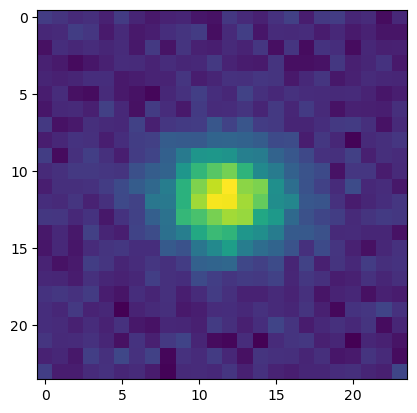

In [56]:
im = m.get_cutout(24, 0, 'image')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im)

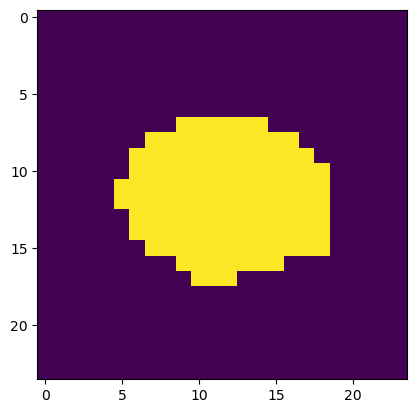

In [57]:
im = m.get_cutout(24, 0, 'seg')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im)

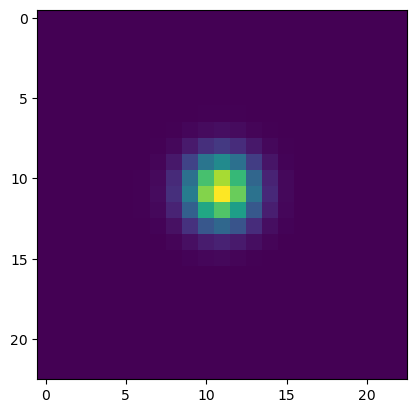

In [58]:
im = m.get_cutout(24, 0, 'psf')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im)